# How to Train Your Own Key Points Detection Networks

![](https://user-images.githubusercontent.com/22118253/69765965-fd65a700-1143-11ea-8804-cd1d33f2e824.png)

In this notebook, we will demonstrate 
- how to train your own KeyPoints detection network and do inference on pictures of traffic cone.

**[Accurate Low Latency Visual Perception for Autonomous Racing: Challenges Mechanisms and Practical Solutions](https://github.com/mit-han-lab/once-for-all)** is an accurate low latency visual perception system introduced by Kieran Strobel, Sibo Zhu, Raphael Chang, and Skanda Koppula.


## 1. Preparation
Let's first install all the required packages:

In [1]:
! sudo apt install unzip
print('Installing numpy...')
! pip3 install numpy 
# tqdm is a package for displaying a progress bar.
print('Installing tqdm (progress bar) ...')
! pip3 install tqdm 
print('Installing matplotlib...')
! pip3 install matplotlib 
print('Installing dataset reader...')
! pip3 install pandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 26 not upgraded.
W: Target Packages (main/binary-amd64/Packages) is configured multiple times in /etc/apt/sources.list.d/google-cloud-sdk.list:1 and /etc/apt/sources.list.d/google-cloud-sdk.list:2
W: Target Packages (main/binary-all/Packages) is configured multiple times in /etc/apt/sources.list.d/google-cloud-sdk.list:1 and /etc/apt/sources.list.d/google-cloud-sdk.list:2
Installing numpy...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing tqdm (progress bar) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing matplotlib...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing dataset reader...
Looking in indexes: h

Let' s clone our repo first...

In [2]:
! git clone https://github.com/RioEvrard1st/MIT-Driverless-CV-TrainingInfra.git

! mv MIT-Driverless-CV-TrainingInfra/RektNet/* .

fatal: destination path 'MIT-Driverless-CV-TrainingInfra' already exists and is not an empty directory.
mv: cannot stat 'MIT-Driverless-CV-TrainingInfra/RektNet/*': No such file or directory


Before we start training, let's download the Cone Detection dataset and the corresponding label and intial training weights. 

In [3]:
! echo "deb [signed-by=/usr/share/keyrings/cloud.google.gpg] http://packages.cloud.google.com/apt cloud-sdk main" | sudo tee -a /etc/apt/sources.list.d/google-cloud-sdk.list
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key --keyring /usr/share/keyrings/cloud.google.gpg add -
! sudo apt-get update
! sudo apt-get install google-cloud-sdk

deb [signed-by=/usr/share/keyrings/cloud.google.gpg] http://packages.cloud.google.com/apt cloud-sdk main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1461  100  1461    0     0  73050      0 --:--:-- --:--:-- --:--:-- 73050
gpg: no valid OpenPGP data found.
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:6 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:8 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Ign:10 https

In [4]:
print("Downloading Training Dataset")
! gsutil cp -p gs://mit-driverless-open-source/RektNet_Dataset.zip ./dataset/
! unzip dataset/RektNet_Dataset.zip -d ./dataset/
! gsutil cp -p gs://mit-driverless-open-source/rektnet-training/rektnet_label.csv ./dataset/
print("Downloading Training and Validation Label")
! gsutil cp -p gs://mit-driverless-open-source/rektnet-training/rektnet_label.csv ./dataset/

Copying gs://mit-driverless-open-source/RektNet_Dataset.zip...
/ [1 files][ 78.3 MiB/ 78.3 MiB]                                                
Operation completed over 1 objects/78.3 MiB.                                     
Archive:  dataset/RektNet_Dataset.zip
replace ./dataset/RektNet_Dataset/vid_30_frame_2342_3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./dataset/RektNet_Dataset/vid_30_frame_2342_3.jpg  
replace ./dataset/RektNet_Dataset/vid_42_frame_773_13.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ./dataset/RektNet_Dataset/vid_42_frame_773_13.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ya
  inflating: ./dataset/RektNet_Dataset/vid_42_frame_773_13.jpg  
replace ./dataset/RektNet_Dataset/vid_37_frame_736_19.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Copying gs://mit-driverless-open-source/rektnet-training/rektnet_label.csv...
/ [1 files][323.1 KiB/323.1 KiB]                                                
Operation completed ove

## 2. Training


First, import all the packages used in this tutorial:

In [5]:
import argparse
import tempfile
import sys
import os
import io
import multiprocessing
import shutil
from tqdm import tqdm
import numpy as np
import cv2
import copy
from datetime import datetime
from tqdm import tqdm
import importlib

import PIL
from PIL import Image, ImageDraw

import torch
from torch.autograd import Variable
from torch.backends import cudnn
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms

import keypoint_net
importlib.reload(keypoint_net)
from keypoint_net import KeypointNet

from cross_ratio_loss import CrossRatioLoss
from utils import Logger
from utils import load_train_csv_dataset, prep_image, visualize_data, vis_tensor_and_save, calculate_distance, calculate_mean_distance
from dataset import ConeDataset
from keypoint_tutorial_util import print_tensor_stats, eval_model, print_kpt_L2_distance

cv2.setRNGSeed(2)
torch.manual_seed(2)
np.random.seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')

visualization_tmp_path = "/outputs/visualization/"

Successfully imported all packages and configured random seed to 17!

Training Config

In [6]:
study_name="tutorial"

current_month = datetime.now().strftime('%B').lower()
current_year = str(datetime.now().year)
if not os.path.exists(os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/')):
    os.makedirs(os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/'))
output_uri = os.path.join('outputs/', current_month + '-' + current_year + '-experiments/' + study_name + '/')

save_file_name = 'logs/' + output_uri.split('/')[-2]
sys.stdout = Logger(save_file_name + '.log')
sys.stderr = Logger(save_file_name + '.error')

# Training related config
INPUT_SIZE = (80, 80) # image size
# KPT_KEYS is a list of strings that represent the keypoint names
KPT_KEYS = ["top", "mid_L_top", "mid_R_top", "mid_L_bot", "mid_R_bot", "bot_L", "bot_R"] # set up geometry loss keys
num_kpt=len(KPT_KEYS)
# intervals: number of times the model parameters will be updated during training before the validation loss is evaluated
intervals = int(2) # for normal training, set it to 4
val_split = float(0.15) # training validation split ratio
# batch_size: number of samples that will be used to compute the loss and update the model's parameters during each training iteration
batch_size= int(8)
# num_epochs: number of times the entire training dataset will be passed through the model
num_epochs= int(4) # for normal training, set it to 1024
train_csv = "dataset/rektnet_label.csv"
dataset_path = "dataset/RektNet_Dataset/"
vis_dataloader = False # visualize dataset
save_checkpoints = True

# Training related hyperparameter
# learning rate
lr = 1e-1 
# rate at which the learning rate of the optimizer is decayed
lr_gamma = 0.999  
# whether to include a geometry loss term in the overall loss function
geo_loss = True
geo_loss_gamma_vert = 0
geo_loss_gamma_horz = 0
# type of loss function
loss_type = "l1_softargmax" # loss function type: l2_softargmax|l2_heatmap|l1_softargmax
# best validation loss
best_val_loss = float('inf')
best_epoch = 0
max_tolerance = 8
tolerance = 0

Caches exist: ./gs/03083f6f8ab6011e5825cf091cb9f452ad56af70975455445b42e72c323f8de2/images.npy and ./gs/03083f6f8ab6011e5825cf091cb9f452ad56af70975455445b42e72c323f8de2/labels.npy!
training image number: 2718
validation image number: 479


Create pytorch dataloaders for train and validation sets.

In [7]:
train_images, train_labels, val_images, val_labels = load_train_csv_dataset(train_csv, validation_percent=val_split, keypoint_keys=KPT_KEYS, dataset_path=dataset_path, cache_location="./gs/")

train_dataset = ConeDataset(images=train_images, labels=train_labels, dataset_path=dataset_path, target_image_size=INPUT_SIZE, save_checkpoints=save_checkpoints, vis_dataloader=vis_dataloader)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=False, num_workers=0)
val_dataset = ConeDataset(images=val_images, labels=val_labels, dataset_path=dataset_path, target_image_size=INPUT_SIZE, save_checkpoints=save_checkpoints, vis_dataloader=vis_dataloader)
val_dataloader = DataLoader(val_dataset, batch_size= 1, shuffle=False, num_workers=0)

Define model, optimizer and loss function.

In [8]:
model = KeypointNet(len(KPT_KEYS), INPUT_SIZE, onnx_mode=False)

model = model.to(device)
if torch.cuda.is_available():
    model.cuda()

# Adam optimizer is used, which is a popular gradient descent optimization algorithm
optimizer = optim.Adam(model.parameters(), lr=lr)
# exponential decay functionfor learning rate
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_gamma)
# loss function is a custom implementation called CrossRatioLoss
loss_func = CrossRatioLoss(loss_type, geo_loss, geo_loss_gamma_horz, geo_loss_gamma_vert)

## Training

In [9]:
for epoch in range(num_epochs):
    print(f"EPOCH {epoch}")
    model.train()
    total_loss = [0,0,0] # location/geometric/total
    batch_num = 0

    train_process = tqdm(train_dataloader)
    for x_batch, y_hm_batch, y_points_batch, image_name, _ in train_process:
        x_batch = x_batch.to(device, non_blocking=True)
        y_hm_batch = y_hm_batch.to(device, non_blocking=True)
        y_points_batch = y_points_batch.to(device, non_blocking=True)

        # Zero the gradients.
        if optimizer is not None:
            optimizer.zero_grad()

        # Compute output and loss.
        output = model(x_batch)
        loc_loss, geo_loss, loss = loss_func(output[0], output[1], y_hm_batch, y_points_batch)
        loss.backward()
        optimizer.step()

        loc_loss, geo_loss, loss = loc_loss.item(), geo_loss.item(), loss.item()
        train_process.set_description(f"Batch {batch_num}. Location Loss: {round(loc_loss,5)}. Geo Loss: {round(geo_loss,5)}. Total Loss: {round(loss,5)}")
        total_loss[0] += loc_loss
        total_loss[1] += geo_loss
        total_loss[2] += loss
        batch_num += 1

    print(f"\tTraining: MSE/Geometric/Total Loss: {round(total_loss[0]/batch_num,10)}/{round(total_loss[1]/batch_num,10)}/{round(total_loss[2]/batch_num,10)}")
    val_loc_loss, val_geo_loss, val_loss = eval_model(model=model, dataloader=val_dataloader, loss_function=loss_func, input_size=INPUT_SIZE)

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        tolerance = 0
    else:
        tolerance += 1

    if save_checkpoints and epoch != 0 and (epoch + 1) % intervals == 0:
        # Save the latest weights
        gs_pt_uri = os.path.join(output_uri, "epoch_{epoch}_loss_{loss}.pt".format(epoch=epoch, loss=round(val_loss, 2)))
        print(f'Saving model to {gs_pt_uri}')
        checkpoint = {'epoch': epoch,
                        'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()}
        torch.save(checkpoint, gs_pt_uri)
    if tolerance >= max_tolerance:
        print(f"Training is stopped due; loss no longer decreases. Epoch {best_epoch} is has the best validation loss.")
        break

## 3. Inference

Download target image file for inference

Text(0.5, 1.0, 'Keypoints Testing Image')

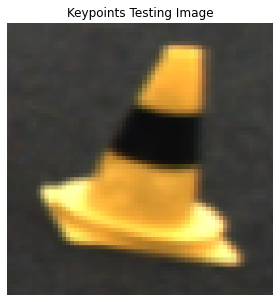

In [10]:
! gsutil cp -p gs://mit-driverless-open-source/test_kpt.png .

import cv2
%matplotlib inline
import matplotlib.pylab as pt

image = cv2.imread("test_kpt.png")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pt.fig = pt.figure(figsize=(5, 5))

pt.imshow(image)
pt.axis('off')
pt.title('Keypoints Testing Image')

Download pretrained weights for inference

In [11]:
! gsutil cp -p gs://mit-driverless-open-source/pretrained_kpt.pt .

In [12]:
model = "pretrained_kpt.pt"
# Check if the image is loaded successfully
if model is None:
    print("Failed to load model")
else:
    print("Model loaded successfully")

Set up config file for inference

In [13]:
model = "pretrained_kpt.pt"
img = "test_kpt.png"
img_size = int(80)
output = "outputs/visualization/"
flip = False
rotate = False

Prepared Image

In [14]:
output_path = output
model_filepath = model
image_filepath = img

img_name = '_'.join(image_filepath.split('/')[-1].split('.')[0].split('_')[-5:])

image_size = (img_size, img_size)

image = cv2.imread(image_filepath)

image = prep_image(image=image,target_image_size=image_size)
image = (image.transpose((2, 0, 1)) / 255.0)[np.newaxis, :]
image = torch.from_numpy(image).type('torch.FloatTensor')

In [15]:
model = KeypointNet()

model.load_state_dict(torch.load(model_filepath).get('model'))
model.eval()
output = model(image)
out = np.empty(shape=(0, output[0][0].shape[2]))
for o in output[0][0]:
    chan = np.array(o.cpu().data)
    cmin = chan.min()
    cmax = chan.max()
    chan -= cmin
    chan /= cmax - cmin
    out = np.concatenate((out, chan), axis=0)
cv2.imwrite(output_path + img_name + "_hm.jpg", out * 255)

True

Text(0.5, 1.0, 'Keypoints Detection Result')

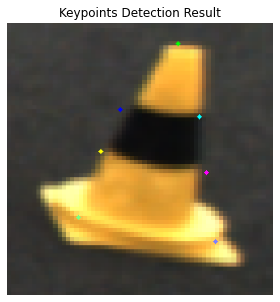

In [16]:
image = cv2.imread(image_filepath)
h, w, _ = image.shape

image = vis_tensor_and_save(image=image, h=h, w=w, tensor_output=output[1][0].cpu().data, image_name=img_name, output_uri=output_path)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pt.fig = pt.figure(figsize=(5, 5))

pt.imshow(image)
pt.axis('off')
pt.title('Keypoints Detection Result')

## 2D to 3D projection

In [21]:

print_kpt_L2_distance(model=model, dataloader=val_dataloader, kpt_keys=KPT_KEYS, study_name=study_name, evaluate_mode=1, input_size=INPUT_SIZE)



RuntimeError: ignored

## Converting pt model to onnx
